# Fashion Product Images Dataset - Data Preprocessing

# 1. Dataset Overview
- **Goal**: The dataset is designed for **fashion product classification and recommendation**. 
It contains a various collection of labeled images of fashion items that allows us to develop intelligent systems that is applicable for : 
**Product classification** by training machine learning to classify  fashion items into multiple categories such as pants, t-shirts and shoes.
**Recommendation system** by training machine learning to recommend similar fashion items based on a given image.
This dataset not only improve automation and efficiency in fashion industry but also improve user experience throughout tailored recommendation capabilities.
- **Source**: [Kaggle Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)
- **Data Files inside Dataset/preprocessed**:
  - `preprocessed/`: Contains all the data after preprocessing.
  - `fashion_products_cleaned_final.csv`: Contains product metadata.
  - `fashion_products_cleaned_final.json`: Contains JSON metadata.
  - `resized_images/`: Contains `.jpg` images of products.
  
- **Number of Observations (Rows)**:
  - Total records: 44424
- **Number of Variables (Columns)**:
  - Total columns: 15
- **Types of Variables**:
  - Categorical (String): 13
  - Numerical (Integer/Float): 3

- **Classes and Labels**:
  - Primary Categories (masterCategory):
  - Apparel (48%)
  - Accessories (25%)
  - Other (26%)
  - Subcategories (subCategory):
  - Topwear (35%)
  - Shoes (17%)
  - Other (49%)
  - Article Type (articleType):
  - T-shirts (16%)
  - Shirts (7%)
  - Other (77%)
  - Gender Target (gender):
  - Men (50%)
  - Women (42%)
  - Other (8%)
  -  Brand (brandName)
  - Various brands represented in the dataset
  - Age Group (ageGroup)
  - Children, Adults, and Unspecified
  - Price (price) & Discounted Price (discountedPrice)
  - Varies across products
  - Season (season)
  - Summer, Winter, and other seasonal classifications
  - Usage (usage)
  - Casual, Formal, and other usage type
  
- **Attributes (Column Names and Description)**:
  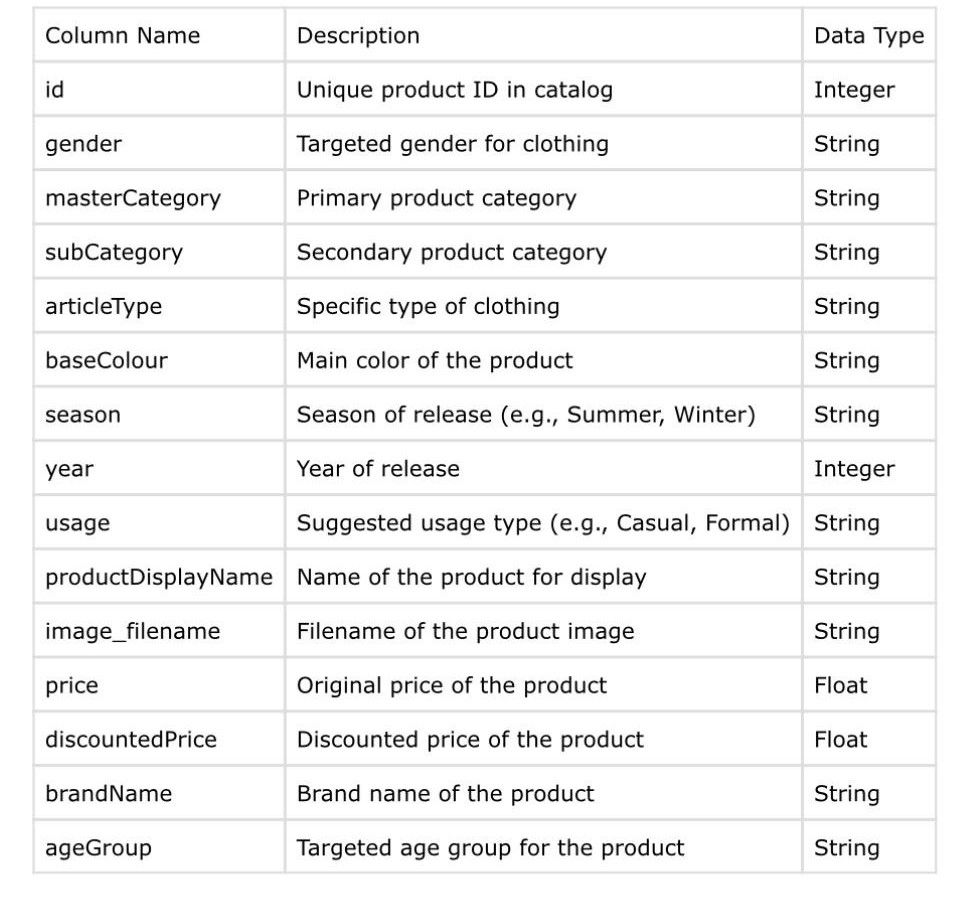

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
dataset_path = '../FashionRecommendationProject/Dataset/'

styles_file = os.path.join(dataset_path, 'styles.csv')
df_styles = pd.read_csv(styles_file, on_bad_lines='skip', encoding='utf-8')

print("Columns in styles.csv:", df_styles.columns.tolist())

Columns in styles.csv: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


In [20]:
styles_json_dir = os.path.join(dataset_path, "styles/")
resized_images_dir = os.path.join(dataset_path, "preprocessed/resized_images/")

# 2. Summary of the dataset

### Here is a sample of the raw dataset:
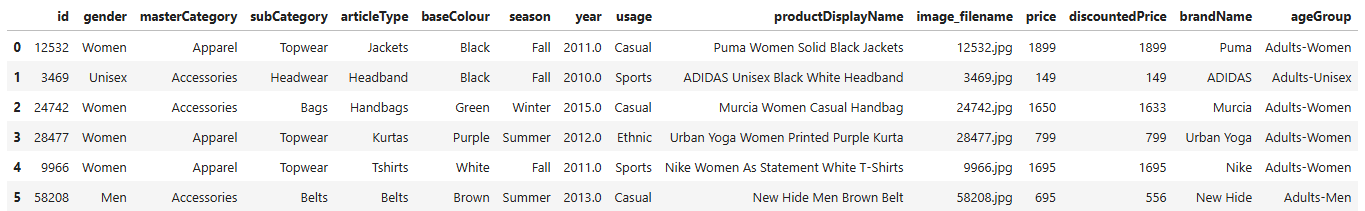

- The dataset has a total number of records: 44424.
- **Mode of Gender and Season**
  The most frequent gender in the dataset is Men, and the most frequent season is Summer.
- **Mean of attribute 'year'** 
 is 2012.8064.
- **Variance of attribute 'year'** 
 is 4.5219.
- **Gender Distribution** 
The figure below visualizes the distribution of gender in the dataset.


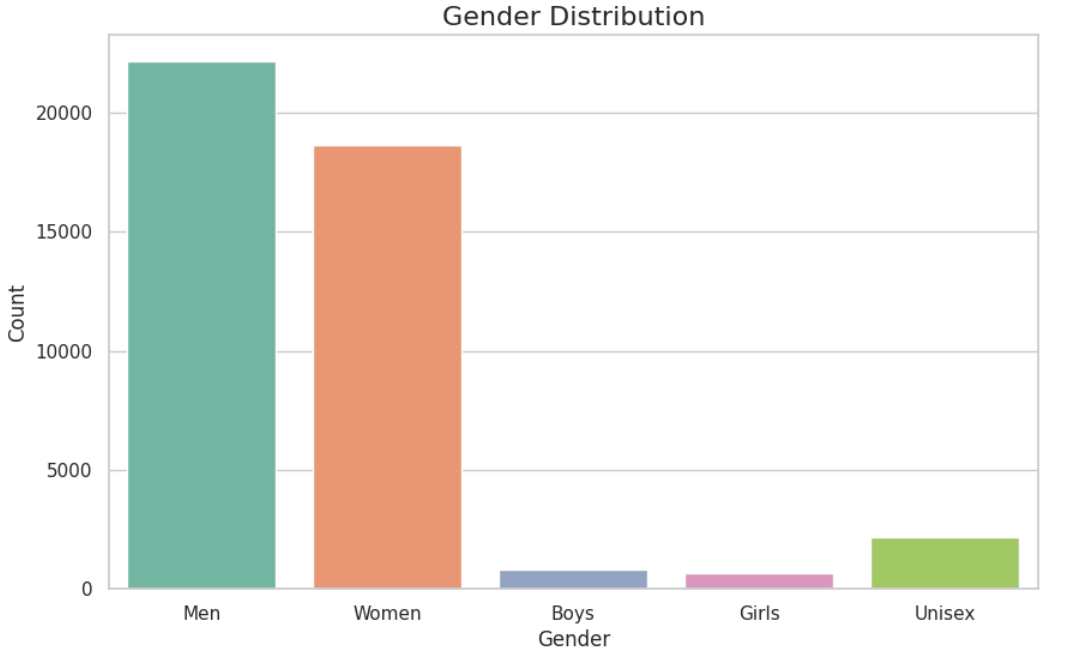

- **Master Category Distribution**
The figure shows the distribution of products across different master categories (e.g., Apparel, Accessories). It helps us understand which product categories are more prevalent in the dataset.


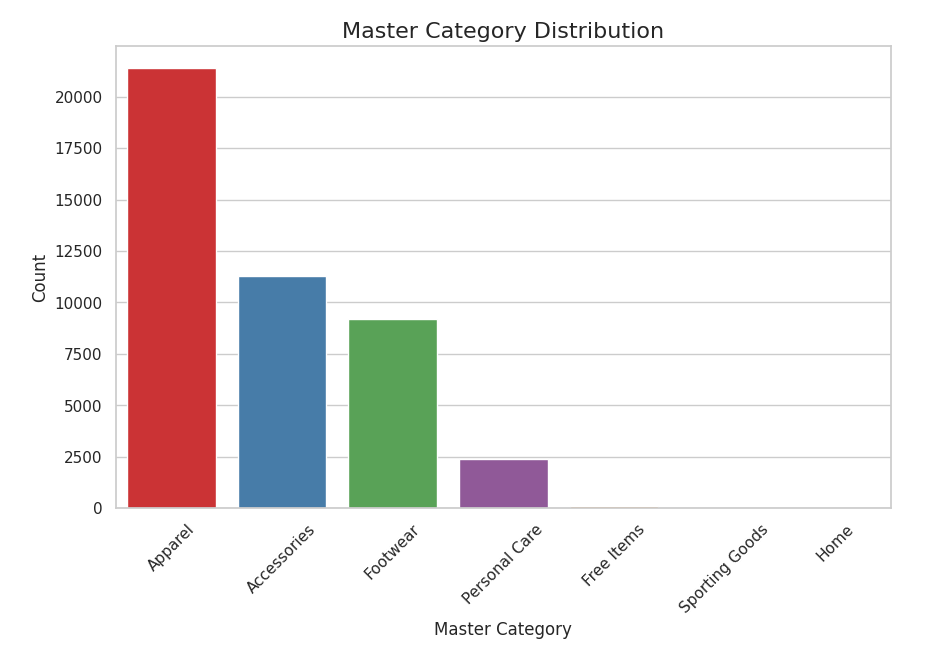

- **Subcategories Distribution**
This third plot displays the top 20 subcategories by count, revealing the most common types of products within the dataset. For example, T-shirts and Jeans may appear as the top products in the Apparel category.


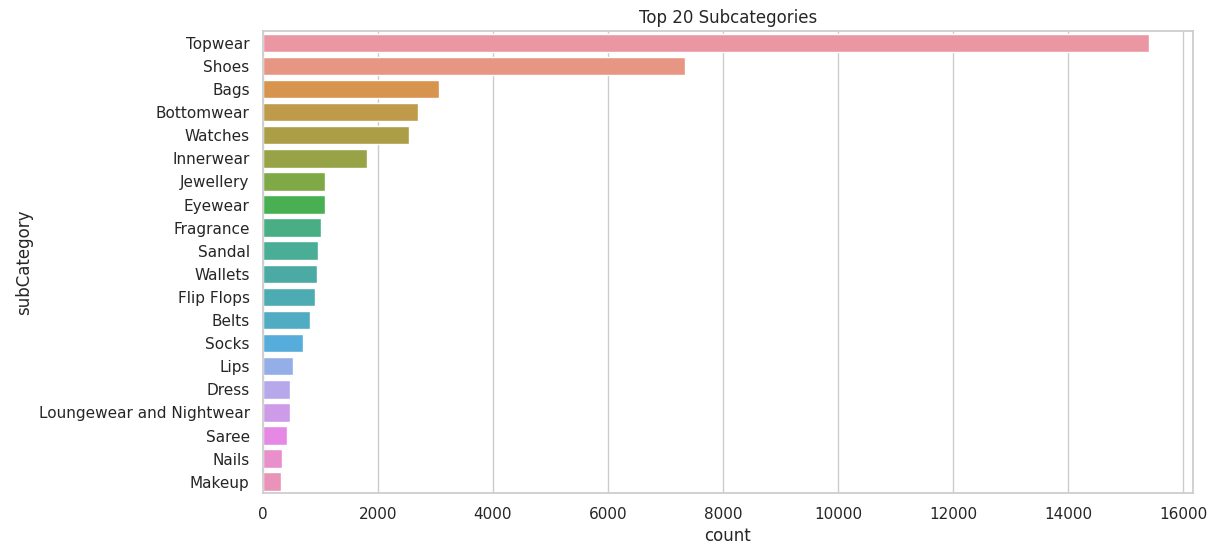

- **Article Types Distribution**
The figure below visualizes the top 20 article types by count, showing the most frequent specific product types.


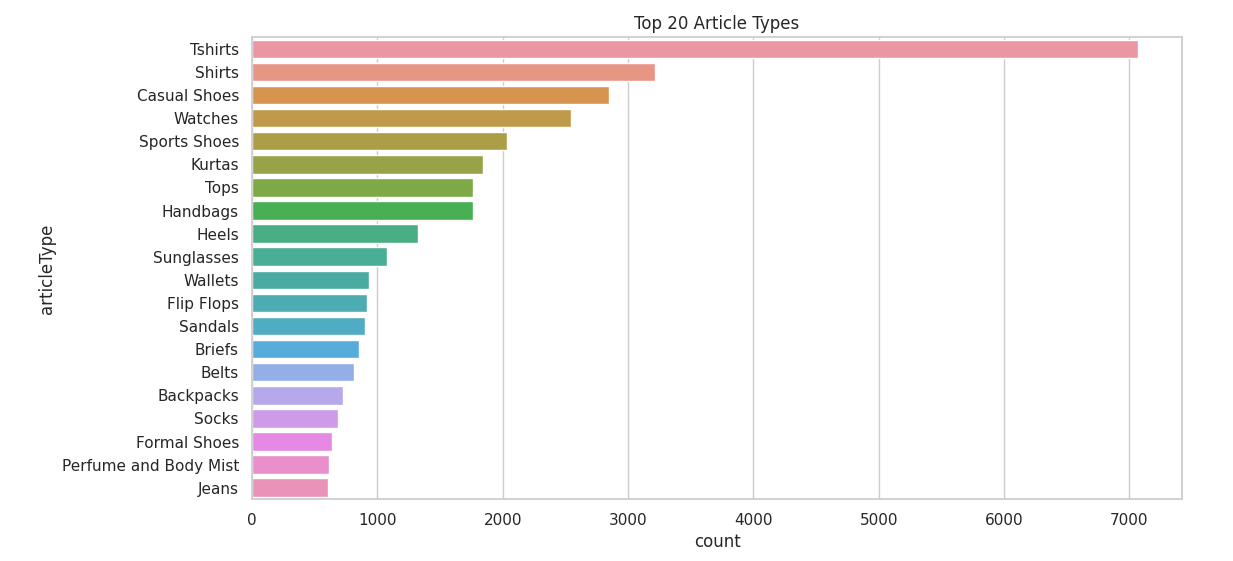

- **Null Value Distribution**
The final chart in our dataset summary shows the count of null (missing) values for each column if any. It highlights the columns where data might be missing, helping us identify where cleaning may be needed.


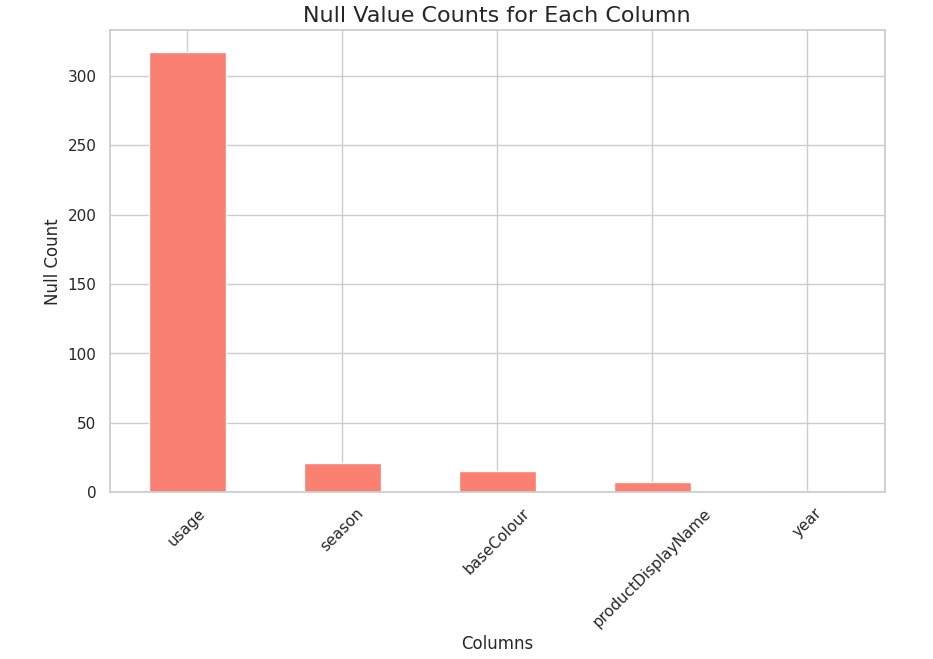


# 3. Preprocessing techniques

## 1. Extracting Required Fields & Renaming Columns

We considered normalizing price and discountedPrice for recommendation purposes. However, after further analysis, we decided NOT to normalize prices because Keeping raw prices allows the recommendation system to suggest products in a similar price range, and it allows customers to get better price-matching suggestions.

In [28]:
json_data = []
json_files = os.listdir(styles_json_dir)

for json_file in json_files:
    if json_file.endswith(".json"):
        json_path = os.path.join(styles_json_dir, json_file)

        with open(json_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)

            data = raw_data.get("data", {})

            json_data.append({
                "image_filename": json_file.replace(".json", ".jpg"),  
                "price": data.get("price"),
                "discountedPrice": data.get("discountedPrice"),
                "brandName": data.get("brandName"),
                "ageGroup": data.get("ageGroup"),
                "gender": data.get("gender"),
                "baseColour": data.get("baseColour"),
                "season": data.get("season")
            })

df_json = pd.DataFrame(json_data)

## 2. Handling Missing Values

In [29]:
resized_image_filenames = [img for img in os.listdir(resized_images_dir) if img.endswith(".jpg")]
df_images = pd.DataFrame({"image_filename": resized_image_filenames})

df_selected = df_images.merge(df_json, on="image_filename", how="left")

print("Extracted columns:", df_selected.columns.tolist())

for col in ["brandName", "ageGroup", "gender", "baseColour", "season"]:
    if col in df_selected.columns:
        df_selected[col] = df_selected[col].fillna("Unknown")

# Convert numeric columns and fill missing values with median
for col in ["price", "discountedPrice"]:
    if col in df_selected.columns:
        df_selected[col] = pd.to_numeric(df_selected[col], errors="coerce")

        if df_selected[col].notnull().sum() > 0:
            df_selected[col] = df_selected[col].fillna(df_selected[col].median())
        else:
            df_selected[col] = df_selected[col].fillna(0)  # If all values are missing, fill with 0

print("Missing values after preprocessing:")
print(df_selected.isnull().sum())


Extracted columns: ['image_filename', 'price', 'discountedPrice', 'brandName', 'ageGroup', 'gender', 'baseColour', 'season']
Missing values after preprocessing:
image_filename     0
price              0
discountedPrice    0
brandName          0
ageGroup           0
gender             0
baseColour         0
season             0
dtype: int64


## 3. Image Preprocessing (Resizing)

In [10]:
image_dir = os.path.join(dataset_path, 'images/')
output_dir = os.path.join(dataset_path, 'preprocessed/resized_images/')
os.makedirs(output_dir, exist_ok=True)

def resize_images(input_dir, output_dir, size=(1048, 1048)):
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        output_path = os.path.join(output_dir, img_name)
        
        try:
            img = Image.open(img_path)
            img = img.resize(size)
            img.save(output_path)
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

resize_images(image_dir, output_dir)
print("Images resized and saved")

Images resized and saved


## 4. Save Preprocessed Data

In [31]:
df_selected.to_csv(os.path.join(dataset_path, 'preprocessed/fashion_products_cleaned.csv'), index=False)
df_selected.to_json(os.path.join(dataset_path, 'preprocessed/fashion_products_cleaned.json'), orient='records', indent=4)
print('Preprocessed dataset saved')

Preprocessed dataset saved


## 5. Update on the Preprocessed Data
after the preprocessing we decided that we don't need the unkown values so we dropped them and instead of recreating the whole process we used the preprocesssed data and dropped the missing values
The final files are `fashion_products_cleaned_final.csv` and `fashion_products_cleaned_final.json` 

In [ ]:
preprocessed_path = os.path.join(dataset_path, "preprocessed")
styles_json_dir = os.path.join(dataset_path, "styles/")
resized_images_dir = os.path.join(preprocessed_path, "resized_images/")
df_selected = pd.read_csv(os.path.join(preprocessed_path, "fashion_products_cleaned.csv"))

# Remove rows where any value in brandName, ageGroup, gender, baseColour, or season is "Unknown"
filtered_df = df_selected[
    ~(df_selected[["brandName", "ageGroup", "gender", "baseColour", "season"]].eq("Unknown")).any(axis=1)
].copy()

# Delete corresponding images that were removed
deleted_images = set(df_selected["image_filename"]) - set(filtered_df["image_filename"])

for img in deleted_images:
    img_path = os.path.join(resized_images_dir, img)
    if os.path.exists(img_path):
        os.remove(img_path)  # Delete the image file
        print(f"Deleted: {img_path}")

# Save the final cleaned dataset
filtered_df.to_csv(os.path.join(preprocessed_path, "fashion_products_cleaned_final.csv"), index=False)

# Save JSON without "Unknown" values
filtered_json = filtered_df.to_dict(orient="records")
clean_json = [{k: v for k, v in record.items() if v != "Unknown"} for record in filtered_json]

with open(os.path.join(preprocessed_path, "fashion_products_cleaned_final.json"), "w") as f:
    json.dump(clean_json, f, indent=4)

print("Final dataset saved! Records with 'Unknown' removed.")

Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/5924.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/6742.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/58944.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/5614.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/7350.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/3867.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/42842.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/42982.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/39336.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/5152.jpg
Deleted: ../FashionRecommendationProject/Dataset/preprocessed\resized_images/42263.jpg
Deleted: ../FashionRecommendationProject/Dataset/